In [179]:
import tensorflow
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from math import sqrt
from numpy import array
from numpy import mean
from pandas import DataFrame
from pandas import concat
from pandas import read_csv
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import RepeatVector 
from keras.layers import TimeDistributed

In [180]:
DATE = 'date'
CLOSE_PRICE = 'close'

In [181]:
### Reading Data from Product Demand Sample Data file and Filtering by One Product

In [182]:
df = pd.read_csv('GOOG.csv' ,encoding='utf-8',nrows=100000)

df[DATE]= pd.to_datetime(df[DATE]) 
df.head()
df = df.set_index(DATE)
df = df.sort_index()
df.head(10)

,volume,open,close,high,low,adjclose
date,,,,,,
2004-08-19,44994500,49.676899,49.845802,51.693783,47.669952,49.845802
2004-08-20,23005800,50.178635,53.805050,54.187561,49.925285,53.805050
2004-08-23,18393200,55.017166,54.346527,56.373344,54.172661,54.346527
2004-08-24,15361800,55.260582,52.096165,55.439419,51.450363,52.096165
2004-08-25,9257400,52.140873,52.657513,53.651051,51.604362,52.657513
2004-08-26,7148200,52.135906,53.606342,53.626213,51.991844,53.606342
2004-08-27,6258300,53.700729,52.732029,53.959049,52.503513,52.732029
2004-08-30,5235700,52.299839,50.675404,52.404160,50.675404,50.675404
2004-08-31,4954800,50.819469,50.854240,51.519913,50.749920,50.854240


In [183]:
### Coverting into a multivariate timeseries data

In [184]:
df = df[[CLOSE_PRICE]]
df[CLOSE_PRICE] =  df[CLOSE_PRICE].astype('float64')
df.head(10)

,close
date,
2004-08-19,49.845802
2004-08-20,53.805050
2004-08-23,54.346527
2004-08-24,52.096165
2004-08-25,52.657513
2004-08-26,53.606342
2004-08-27,52.732029
2004-08-30,50.675404
2004-08-31,50.854240


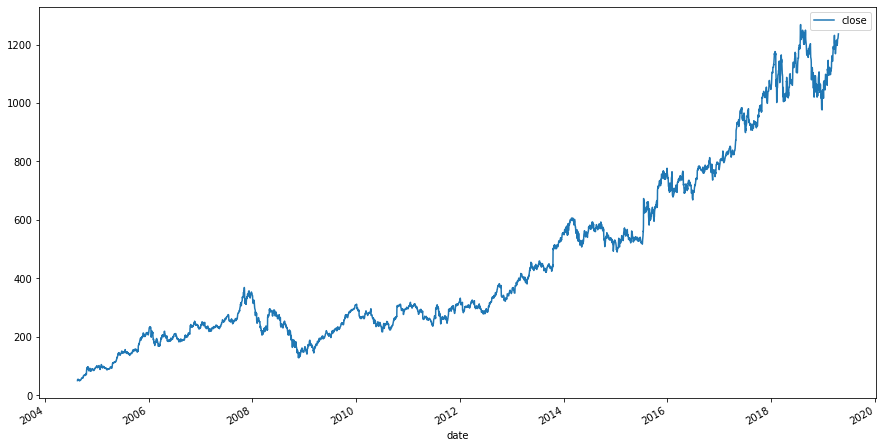

In [185]:
df.plot(use_index=True,figsize=(15,8))

### Remove Trend and Display the Graph

In [201]:
# transform scale
data = df.values
# data = X.reshape(len(X), 1)
# scaler = MinMaxScaler(feature_range=(0, 1))
# scaler = scaler.fit(data)
# data = scaler.transform(data)
# data[-10:]

In [202]:
def split_sequence(sequence, n_steps_in, n_steps_out): 
    X, y = list(), list()
    for i in range(len(sequence)):
    # find the end of this pattern
        end_ix = i + n_steps_in
        out_end_ix = end_ix + n_steps_out
        if out_end_ix > len(sequence):
            break
    # gather input and output parts of the pattern
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix:out_end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return array(X), array(y)

In [203]:
STEPS_IN = 30
STEPS_OUT = 7
X,y = split_sequence(data, STEPS_IN, STEPS_OUT)


In [189]:
print(X.shape)
print(y.shape)
# for i in range(len(X)):
#   print(X[i], y[i])

(3656, 30, 1)
(3656, 7, 1)


In [190]:
n_features = 1
X_transformed = X.reshape((X.shape[0], X.shape[1], n_features))
y_transformed = y.reshape((y.shape[0], y.shape[1], n_features))
X_transformed.shape

(3656, 30, 1)

In [191]:
y_transformed.shape

(3656, 7, 1)

### Model Definition

In [208]:
# define model
model = Sequential()
model.add(LSTM(100, activation='relu', input_shape=(n_steps_in, n_features))) 
model.add(RepeatVector(n_steps_out))
model.add(LSTM(100, activation='relu', return_sequences=True)) 
model.add(TimeDistributed(Dense(1)))
model.compile(optimizer='adam', loss='mse')

In [209]:
# fit model
model.fit(X_transformed, y_transformed, epochs=40, verbose=1)

Epoch 1/40
3656/3656 [==============================] - 2s 622us/step - loss: 90006.0748
Epoch 2/40
3656/3656 [==============================] - 2s 455us/step - loss: 146947.6518
Epoch 3/40
3656/3656 [==============================] - 2s 451us/step - loss: 1228.8384
Epoch 4/40
3656/3656 [==============================] - 2s 449us/step - loss: 1211.8931
Epoch 5/40
3656/3656 [==============================] - 2s 450us/step - loss: 1513.6434
Epoch 6/40
3656/3656 [==============================] - 2s 448us/step - loss: 111096.6003
Epoch 7/40
3656/3656 [==============================] - 2s 450us/step - loss: 19372.3102
Epoch 8/40
3656/3656 [==============================] - 2s 454us/step - loss: 4625.1066
Epoch 9/40
3656/3656 [==============================] - 2s 448us/step - loss: 2652.8524
Epoch 10/40
3656/3656 [==============================] - 2s 448us/step - loss: 1963.1511
Epoch 11/40
3656/3656 [==============================] - 2s 455us/step - loss: 14988.8664
Epoch 12/40
3656/3656 [

In [217]:
def visualize_predictions(x_input, y):
#     x_input = data[-67:-37]
    x_input = x_input.reshape((1, 30, 1))
#     y = data[-37:-30]
    y_pred = model.predict(x_input, verbose=0).ravel()
#     print(y_pred)
    mse = np.mean((y - y_pred)**2)
    return y_pred
#     plt.figure(figsize=(8,4))
#     plt.plot(y, label='actual_data')
#     plt.plot(y_pred, label='predicted_data')
#     plt.legend()
#     plt.show()

In [227]:
total_y_actual = []
total_y_pred = []
for i in range(2,50):
    X_test = X[-i].ravel()
    y_test = y[-i].ravel()
    total_y_actual.append(y_test)
    total_y_pred.append(visualize_predictions(X_test, y_test))
    

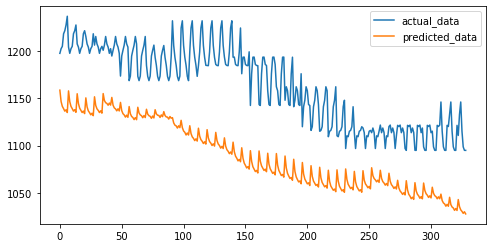

In [228]:
plt.figure(figsize=(8,4))
plt.plot(np.array(total_y_actual[:-1]).ravel(), label='actual_data')
plt.plot(np.array(total_y_pred[:-1]).ravel(), label='predicted_data')
plt.legend()
plt.show()